<div class='bar_title'></div>

*Smart Cities and Geospatial Data Analysis*

# Assignment 8: Point Pattern Analysis

Gunther Gust / Ignacio Ubeda<br>
Chair for Enterprise AI

Winter Semester 23/24

*Credits: Most of the material is taken from [Arribas-Bel, Geographic Data Science](https://darribas.org/gds_course/content/home.html#)*

In [1]:
import os
import mapclassify
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

## Task I: AirBnb distribution in Barcelona

In this task, you will explore patterns in the distribution of the location of AirBnb properties in Barcelona. For that, we will use data of the locations of the properties available as of September 6th. 2023. In the [Inside AirBnb webpage](http://insideairbnb.com/get-the-data) you'll find the same type of data but for other cities too! You can get insights from the different cities through this data.

### Reading data

In [2]:
filepath = os.path.join('data', 'bcn_listings.csv.gz')
abb = pd.read_csv(filepath)

print(type(abb))
print(abb.shape)
abb.head()

<class 'pandas.core.frame.DataFrame'>
(18086, 75)


id                          listing_url       scrape_id last_scraped  \
0   18674   https://www.airbnb.com/rooms/18674  20230906022853   2023-09-06   
1   23197   https://www.airbnb.com/rooms/23197  20230906022853   2023-09-06   
2  117010  https://www.airbnb.com/rooms/117010  20230906022853   2023-09-06   
3   32711   https://www.airbnb.com/rooms/32711  20230906022853   2023-09-06   
4  118228  https://www.airbnb.com/rooms/118228  20230906022853   2023-09-06   

            source                                               name  \
0      city scrape  Rental unit in Barcelona · ★4.30 · 3 bedrooms ...   
1      city scrape  Rental unit in Sant Adria de Besos · ★4.77 · 3...   
2  previous scrape  Rental unit in Barcelona · ★4.55 · 3 bedrooms ...   
3      city scrape  Rental unit in Barcelona · ★4.46 · 2 bedrooms ...   
4  previous scrape  Rental unit in Barcelona · ★4.56 · 3 bedrooms ...   

                                         description  \
0  110m2 apartment to rent in Barcelona. Located ...   
1  Beautiful spacious apartment, large terrace, 5...   
2  Have an authentic Barcelona experience! Modern...   
3  A lovely two bedroom apartment only 250 m from...   
4  Modern 100m2 recently decorated apartment with...   

                               neighborhood_overview  \
0  Apartment in Barcelona located in the heart of...   
1  Strategically located in the Parc del Fòrum, a...   
2  Apartment is located just 240 meters from Sagr...   
3  What's nearby  <br />This apartment is located...   
4  Apartment is located just 240 meters from Sagr...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/13031453/413c...    71615  ...   
1  https://a0.muscache.com/pictures/miso/Hosting-...    90417  ...   
2  https://a0.muscache.com/pictures/4052d8b5-7352...   567180  ...   
3  https://a0.muscache.com/pictures/357b25e4-f414...   135703  ...   
4  https://a0.muscache.com/pictures/c4b34854-5db1...   567180  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.65                   4.78                4.27   
1                        4.99                   4.60                4.64   
2                        4.91                   4.86                4.59   
3                        4.85                   4.86                4.52   
4                        4.74                   4.90                4.52   

       license instant_bookable calculated_host_listings_count  \
0  HUTB-002062                t                             30   
1   HUTB005057                f                              2   
2   HUTB000331                f                             19   
3  HUTB-001722                t                              3   
4  HUTB-000328                f                             19   

  calculated_host_listings_count_entire_homes  \
0                                          30   
1                                           2   
2                                          19   
3                                           3   
4                                          19   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.30  
1                                           0              0.48  
2                                           0              0.33  
3                                           0              0.64  
4                                           0              0.34  

[5 rows x 75 columns]

This gives us a DataFrame with the following information:

In [3]:
abb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18086 entries, 0 to 18085
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            18086 non-null  int64  
 1   listing_url                                   18086 non-null  object 
 2   scrape_id                                     18086 non-null  int64  
 3   last_scraped                                  18086 non-null  object 
 4   source                                        18086 non-null  object 
 5   name                                          18086 non-null  object 
 6   description                                   17968 non-null  object 
 7   neighborhood_overview                         10108 non-null  object 
 8   picture_url                                   18086 non-null  object 
 9   host_id                                       18086 non-null 

Note that `abb` doesn't have a `geometry` column but instead two diferent columns for `latitude` and `longitude`. In essence, `abb` is only a DataFrame (and not a GeoDataFrame) and therefore we can not use all the methods and attributes for GeoDataFrames (e.g. `.area`, `.crs`, etc). 

We can transform it to a GeoDataFrame and set the geometry with the following lines of code. Since we have a `latitude` and `longitude` column, we need to use `ESPG:4326` as CRS.

**This is a common (and important) step when working with GeoDataFrames. In general, the datasets available in the internet are not always stored in a way to directly read it as a GeoDataFrame and thus we need to convert it and set the geometry first to start our analysis.**

In [4]:
abb = gpd.GeoDataFrame(abb, geometry=gpd.points_from_xy(abb['longitude'], abb['latitude']))
abb = abb.set_crs('epsg:4326')

print(type(abb))
print(abb.shape)
abb.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(18086, 76)


id                          listing_url       scrape_id last_scraped  \
0   18674   https://www.airbnb.com/rooms/18674  20230906022853   2023-09-06   
1   23197   https://www.airbnb.com/rooms/23197  20230906022853   2023-09-06   
2  117010  https://www.airbnb.com/rooms/117010  20230906022853   2023-09-06   
3   32711   https://www.airbnb.com/rooms/32711  20230906022853   2023-09-06   
4  118228  https://www.airbnb.com/rooms/118228  20230906022853   2023-09-06   

            source                                               name  \
0      city scrape  Rental unit in Barcelona · ★4.30 · 3 bedrooms ...   
1      city scrape  Rental unit in Sant Adria de Besos · ★4.77 · 3...   
2  previous scrape  Rental unit in Barcelona · ★4.55 · 3 bedrooms ...   
3      city scrape  Rental unit in Barcelona · ★4.46 · 2 bedrooms ...   
4  previous scrape  Rental unit in Barcelona · ★4.56 · 3 bedrooms ...   

                                         description  \
0  110m2 apartment to rent in Barcelona. Located ...   
1  Beautiful spacious apartment, large terrace, 5...   
2  Have an authentic Barcelona experience! Modern...   
3  A lovely two bedroom apartment only 250 m from...   
4  Modern 100m2 recently decorated apartment with...   

                               neighborhood_overview  \
0  Apartment in Barcelona located in the heart of...   
1  Strategically located in the Parc del Fòrum, a...   
2  Apartment is located just 240 meters from Sagr...   
3  What's nearby  <br />This apartment is located...   
4  Apartment is located just 240 meters from Sagr...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/13031453/413c...    71615  ...   
1  https://a0.muscache.com/pictures/miso/Hosting-...    90417  ...   
2  https://a0.muscache.com/pictures/4052d8b5-7352...   567180  ...   
3  https://a0.muscache.com/pictures/357b25e4-f414...   135703  ...   
4  https://a0.muscache.com/pictures/c4b34854-5db1...   567180  ...   

  review_scores_location review_scores_value      license instant_bookable  \
0                   4.78                4.27  HUTB-002062                t   
1                   4.60                4.64   HUTB005057                f   
2                   4.86                4.59   HUTB000331                f   
3                   4.86                4.52  HUTB-001722                t   
4                   4.90                4.52  HUTB-000328                f   

  calculated_host_listings_count calculated_host_listings_count_entire_homes  \
0                             30                                          30   
1                              2                                           2   
2                             19                                          19   
3                              3                                           3   
4                             19                                          19   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  \
0                                           0              0.30   
1                                           0              0.48   
2                                           0              0.33   
3                                           0              0.64   
4                                           0              0.34   

                   geometry  
0  POINT (2.17262 41.40556)  
1  POINT (2.21975 41.41243)  
2  POINT (2.17457 41.40647)  
3  POINT (2.17015 41.40566)  
4  POINT (2.17460 41.40653)  

[5 rows x 76 columns]

Now `abb` is a GeoDataFrame and we can use the attributes of this type of objects. For example, we can check the CRS: 

In [5]:
abb.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Furthermore, for an ancillary geography, we will use the neighborhoods provided by the same source:

In [6]:
filepath = os.path.join('data', 'bcn_neighbourhoods.geojson')
neis = gpd.read_file(filepath)

print(type(neis))
print(neis.shape)
neis.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(75, 3)


neighbourhood neighbourhood_group  \
0                         el Raval        Ciutat Vella   
1                   el Barri Gòtic        Ciutat Vella   
2           la Dreta de l'Eixample            Eixample   
3  l'Antiga Esquerra de l'Eixample            Eixample   
4   la Nova Esquerra de l'Eixample            Eixample   

                                            geometry  
0  MULTIPOLYGON (((2.17737 41.37532, 2.17852 41.3...  
1  MULTIPOLYGON (((2.18287 41.38074, 2.18289 41.3...  
2  MULTIPOLYGON (((2.17091 41.40182, 2.17332 41.3...  
3  MULTIPOLYGON (((2.15971 41.38298, 2.15857 41.3...  
4  MULTIPOLYGON (((2.14998 41.37559, 2.14982 41.3...

In [7]:
neis.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   neighbourhood        75 non-null     object  
 1   neighbourhood_group  75 non-null     object  
 2   geometry             75 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.9+ KB


In [8]:
neis.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

---
With these at hand, get to work with the following challenges:

### Create a jointplot of the property locations

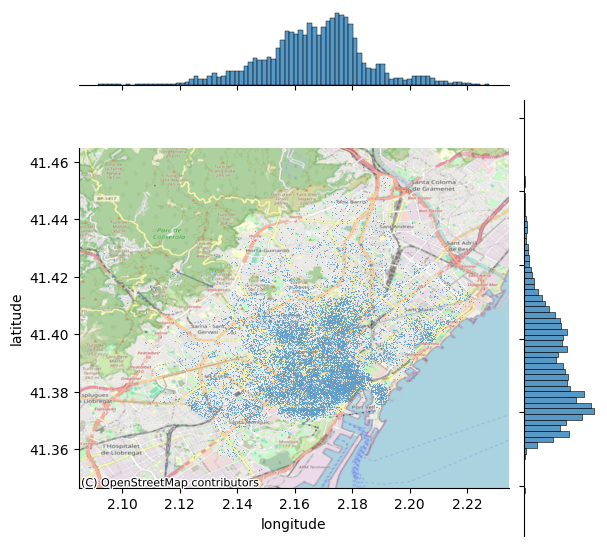

In [9]:
# Generate scatter plot
joint_axes = sns.jointplot(x="longitude", y="latitude", data=abb, s=0.5)

cx.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=cx.providers.OpenStreetMap.Mapnik,
)

### Create a Hex binning map of the property locations

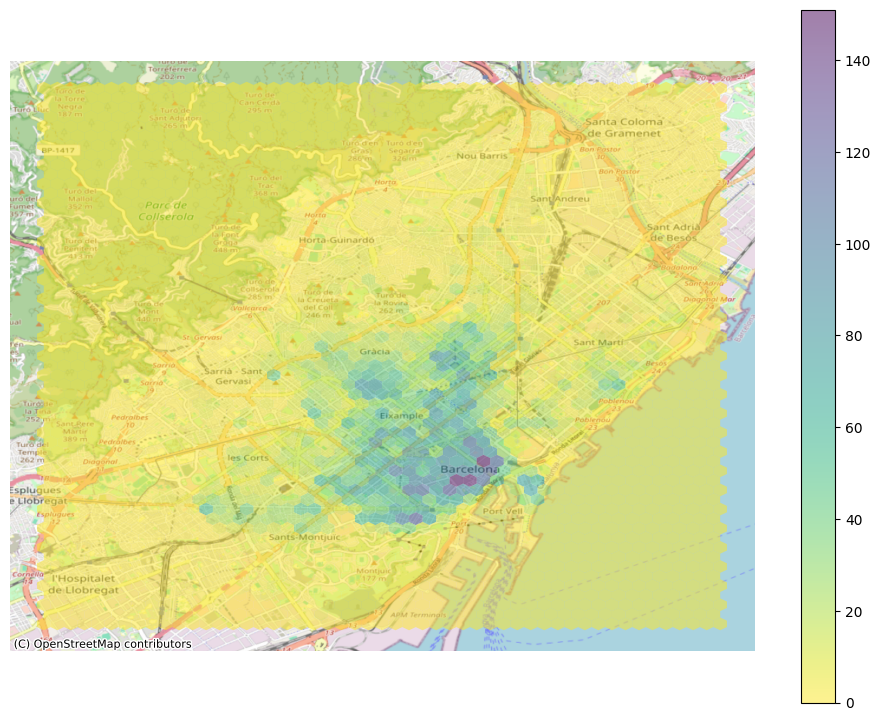

In [10]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))

# Generate and add hexbin
hb = ax.hexbin(
    abb["longitude"],
    abb["latitude"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)

# Add basemap
cx.add_basemap(ax, crs=abb.crs, source=cx.providers.OpenStreetMap.Mapnik)

plt.colorbar(hb)
ax.set_axis_off()
plt.show()

### Compute and display a kernel density estimate (KDE) of the distribution of the properties

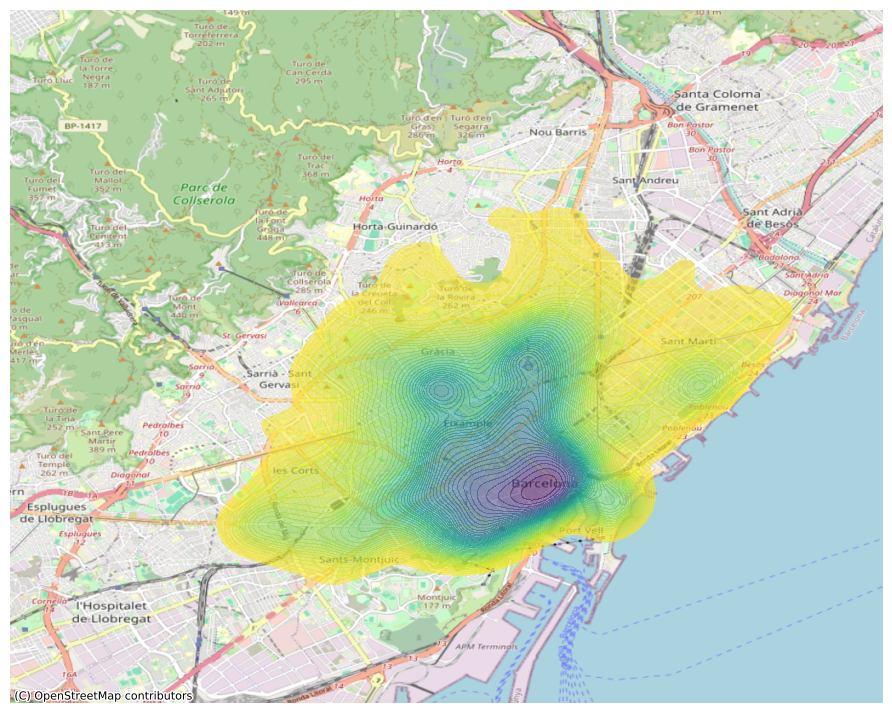

In [11]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))

sns.kdeplot(
    x="longitude",
    y="latitude",
    data=abb,
    n_levels=50,
    fill=True,
    alpha=0.55,
    cmap="viridis_r",
    ax=ax
)

# Add basemap
cx.add_basemap(ax, crs=abb.crs, source=cx.providers.OpenStreetMap.Mapnik)

ax.set_axis_off()
plt.show()

### Using the neighbourhood layer:

#### Obtain a count of property by neighbourhood

**Note:** the neighborhood name is present in the property table (`abb`) as `"neighbourhood_cleansed"` and you can merge it to the neighborhoods table (`neis`) through that. Since we have common column to merge both tables, this is a "vanilla" join (i.e. not a spatial one)

In [12]:
#count the number of properties by neighborhood
count_of_properties_by_neis = abb['neighbourhood_cleansed'].value_counts().reset_index(drop=False)

#Merge geometries with counts ("left" to don't lose any neighborhood)
count_of_properties_by_neis = pd.merge(neis, count_of_properties_by_neis, how='left', left_on='neighbourhood', right_on='neighbourhood_cleansed')

#Impute all values that are not present in the listings with zero
count_of_properties_by_neis.loc[pd.isna(count_of_properties_by_neis['count']), 'count'] = 0

print(type(count_of_properties_by_neis))
print(count_of_properties_by_neis.shape)
count_of_properties_by_neis.sort_values('count', ascending=False).head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(75, 5)


neighbourhood neighbourhood_group  \
2                  la Dreta de l'Eixample            Eixample   
0                                el Raval        Ciutat Vella   
1                          el Barri Gòtic        Ciutat Vella   
6   Sant Pere, Santa Caterina i la Ribera        Ciutat Vella   
34                      la Vila de Gràcia              Gràcia   

                                             geometry  \
2   MULTIPOLYGON (((2.17091 41.40182, 2.17332 41.3...   
0   MULTIPOLYGON (((2.17737 41.37532, 2.17852 41.3...   
1   MULTIPOLYGON (((2.18287 41.38074, 2.18289 41.3...   
6   MULTIPOLYGON (((2.18346 41.39061, 2.18460 41.3...   
34  MULTIPOLYGON (((2.15959 41.40913, 2.16043 41.4...   

                   neighbourhood_cleansed   count  
2                  la Dreta de l'Eixample  2233.0  
0                                el Raval  1456.0  
1                          el Barri Gòtic  1232.0  
6   Sant Pere, Santa Caterina i la Ribera  1125.0  
34                      la Vila de Gràcia  1064.0

#### Create a raw count choropleth

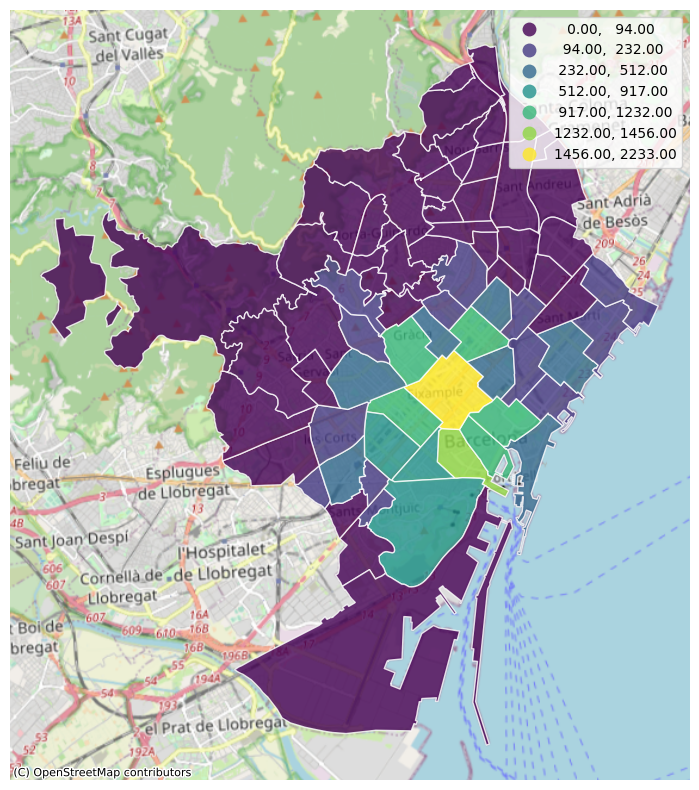

In [13]:
#Visualize with a choropleth
f, ax = plt.subplots(1, figsize=(10, 10))

#fisher jenks is the one that gives the better vis for this dataset, try the other ones!
count_of_properties_by_neis.to_crs(epsg="25830").plot(ax=ax, column='count', scheme='fisher_jenks', alpha=0.8, edgecolor='white', legend=True, k=7)

cx.add_basemap(ax=ax, crs=count_of_properties_by_neis.to_crs(epsg="25830").crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

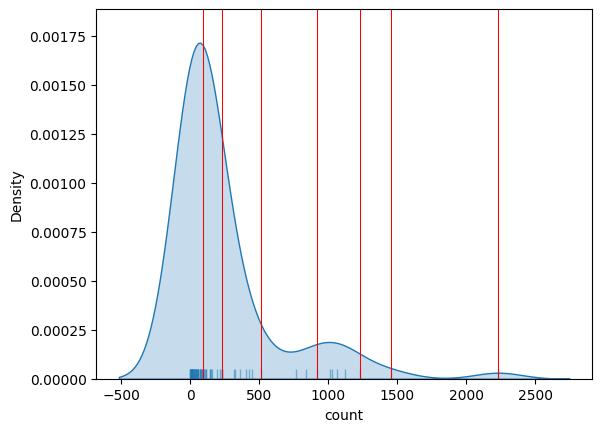

In [13]:
#Plot KDE with classification bins (for understing the underlying distribution)
classi = mapclassify.FisherJenks(count_of_properties_by_neis["count"], k=7)

# Set up the figure
f, ax = plt.subplots(1)

# Plot the kernel density estimation (KDE)
sns.kdeplot(count_of_properties_by_neis["count"], fill=True)

# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(count_of_properties_by_neis["count"], alpha=0.5)

# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)

# Display image
plt.show()

#### Create a choropleth of the density of properties by polygon

**Note:** the density of properties of a polygon is defined as the count of properties divided by the area of the polygon.

**Hint 1:** Check into the `UserWarning` when trying the compute the area and fix it. You can use `"ESPG:25830"` for it. Then convert the area to km2.

In [17]:
#Compute area (in km2)
count_of_properties_by_neis['area'] = (count_of_properties_by_neis.to_crs(epsg="25830").area)/1_000_000 

#Compute density (unit is count / km2)
count_of_properties_by_neis['density'] = count_of_properties_by_neis['count'] / count_of_properties_by_neis['area']

count_of_properties_by_neis.sort_values('density', ascending=False).head(6)

neighbourhood neighbourhood_group  \
1                         el Barri Gòtic        Ciutat Vella   
0                               el Raval        Ciutat Vella   
9                            Sant Antoni            Eixample   
2                 la Dreta de l'Eixample            Eixample   
6  Sant Pere, Santa Caterina i la Ribera        Ciutat Vella   
8                     la Sagrada Família            Eixample   

                                            geometry  \
1  MULTIPOLYGON (((2.18287 41.38074, 2.18289 41.3...   
0  MULTIPOLYGON (((2.17737 41.37532, 2.17852 41.3...   
9  MULTIPOLYGON (((2.16764 41.37518, 2.16785 41.3...   
2  MULTIPOLYGON (((2.17091 41.40182, 2.17332 41.3...   
6  MULTIPOLYGON (((2.18346 41.39061, 2.18460 41.3...   
8  MULTIPOLYGON (((2.17502 41.40041, 2.17332 41.3...   

                  neighbourhood_cleansed   count      area      density  
1                         el Barri Gòtic  1232.0  0.845742  1456.708820  
0                               el Raval  1456.0  1.103326  1319.645896  
9                            Sant Antoni   917.0  0.804585  1139.717967  
2                 la Dreta de l'Eixample  2233.0  2.133026  1046.869700  
6  Sant Pere, Santa Caterina i la Ribera  1125.0  1.119301  1005.091500  
8                     la Sagrada Família  1016.0  1.055739   962.359126

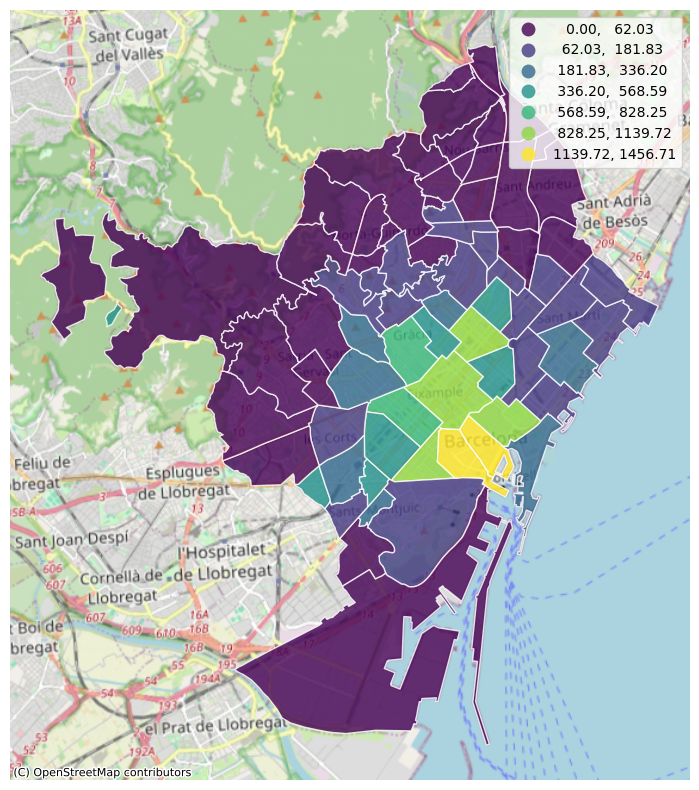

In [15]:
#Visualize with a choropleth
f, ax = plt.subplots(1, figsize=(10, 10))

#fisher jenks is the one that gives the better vis for this dataset, try the other ones!
count_of_properties_by_neis.to_crs(epsg="25830").plot(ax=ax, column='density', scheme='fisher_jenks', alpha=0.8, edgecolor='white', legend=True, k=7)

cx.add_basemap(ax=ax, crs=count_of_properties_by_neis.to_crs(epsg="25830").crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()

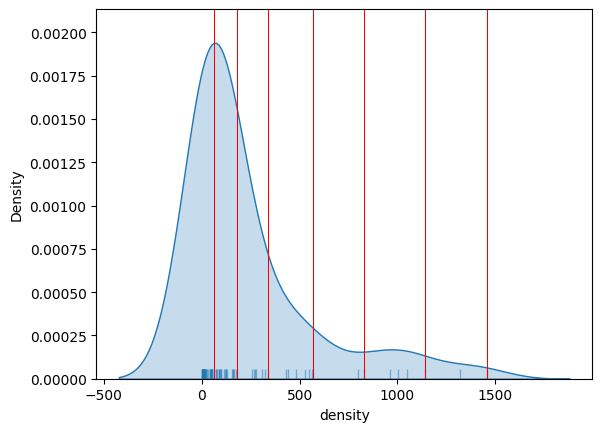

In [16]:
#Plot KDE with classification bins (for understing the underlying distribution)
classi = mapclassify.FisherJenks(count_of_properties_by_neis["density"], k=7)

# Set up the figure
f, ax = plt.subplots(1)

# Plot the kernel density estimation (KDE)
sns.kdeplot(count_of_properties_by_neis["density"], fill=True)

# Add a blue tick for every value at the bottom of the plot (rugs)
sns.rugplot(count_of_properties_by_neis["density"], alpha=0.5)

# Loop over each break point and plot a vertical red line
for cut in classi.bins:
    plt.axvline(cut, color='red', linewidth=0.75)

# Display image
plt.show()

### Analyse the above plots. Answer at least the following:
- *What do you find?*
- *How is the spatial distribution of properties?*
- *Which visualization is better in this case? why?*

#### Answer the question here:

*How is the spatial distribution of properties?*

Interestingly, the distribution of properties is concentric. The main hotspot is in the city center close to the seaside (corresponding to the intersection of "el Barri Gòtic", "el Raval" and "Sant Pere, Santa Caterina i la Ribera", all neighborhoods from "Ciutat Vella"). Then the distribution of properties decreases as it moves away from this hotspot. From the KDE, we can see there are also two hotspots (but less intense) near "Gracia" (this corresponds to "la Vila de Gràcia" neighborhood) and near "Sagrada Familia" (this corresponds to "la Sagrada Família" neighborhood)

*Which visualization is better in this case? why?*

This is a tricky question and the answer is: "It depends". If we are only interested on the distribution of properties, then the KDE is the best plot because it doesn't introduce any "artificial" borders (like the neighborhoods choroplets or hexbin plots), thus letting us spot concentration of properties that lies in the borders of two (or more) neighborhoods. The jointplot doesn't include any "artificial" border too, but is difficult to interpret mainly because of overlapping points. 

However, only looking into the KDE plot doesn't give us any information regarding the neighborhoods. If we have to decide which choropleth is better, we'd select the density plot because is a "normalized" version of the raw count make it more comparable. Note how the hotspots (highlighted in yellow in both plots) change because of this: in the raw count plot the hotspot is in "la Dreta de l'Eixample" but in the density plot, the hostpots are in "el Barri Gòtic" and "el Raval" (closer to the seaside). Nevertheless is more difficult to spot concentration that lies in the intersection of the borders.

The idea behind hexbins is the same: since each hex has the same area, the count and the density will have exactly the same value make it more comparable. However, suffers the same issue as the KDE plot because it doesn't give us any information regarding the neighborhoods.

One possible solution to combine the "best of both worlds" is to create a multilayer map with the neighborhood borders and the KDE plot on top of that. We won't loose the ability to spot concentration in the intersections and we'll have information regarding the neighborhoods as well.

## Task II: Clusters of Indian cities

For this one, we are going to use a dataset on the location of populated places in India provided by [`http://geojson.xyz`](http://geojson.xyz). The original table covers the entire world so, to get it ready for you to work on it, we need to prepare it:



### Reading data

In [53]:
filepath = os.path.join('data', 'ne_50m_populated_places_simple.geojson')
places = gpd.read_file(filepath)

#filter by only places from "India"
places = places.loc[places['adm0name'] == 'India'].reset_index(drop=True)

print(type(places))
print(places.shape)
places.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(69, 37)


scalerank  natscale  labelrank        name namepar  namealt  diffascii  \
0          4        50          1  Chandigarh    None     None          0   
1          4        50          1       Jammu    None     None          0   
2          4        50          1    Sholapur    None  Solapur          0   
3          4        50          1  Aurangabad    None     None          0   
4          4        50          1       Nasik    None   Nashik          0   

    nameascii  adm0cap  capalt  ... pop_other  rank_max  rank_min geonameid  \
0  Chandigarh        0       0  ...   2436384        11        11   1274746   
1       Jammu        0       0  ...   2567923        11        10   1269321   
2    Sholapur        0       0  ...    961272        12        11   1256436   
3  Aurangabad        0       0  ...   1191845        12        12   1278149   
4       Nasik        0       0  ...   2128331        12        12   1261731   

     meganame      ls_name ls_match checkme     featureclass  \
0  Chandigarh   Chandigarh        1       5  Admin-1 capital   
1       Jammu        Jammu        1       0  Populated place   
2     Solapur     Sholapur        1       0  Populated place   
3  Aurangabad  Aurangabad2        1       0  Populated place   
4      Nashik        Nasik        1       0  Populated place   

                    geometry  
0  POINT (76.77806 30.72194)  
1  POINT (74.84479 32.71373)  
2  POINT (75.89806 17.67235)  
3  POINT (75.31836 19.89764)  
4  POINT (73.77804 20.00236)  

[5 rows x 37 columns]

In [54]:
places.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   scalerank     69 non-null     int64   
 1   natscale      69 non-null     int64   
 2   labelrank     69 non-null     int64   
 3   name          69 non-null     object  
 4   namepar       7 non-null      object  
 5   namealt       16 non-null     object  
 6   diffascii     69 non-null     int64   
 7   nameascii     69 non-null     object  
 8   adm0cap       69 non-null     int64   
 9   capalt        69 non-null     int64   
 10  capin         0 non-null      object  
 11  worldcity     69 non-null     int64   
 12  megacity      69 non-null     int64   
 13  sov0name      69 non-null     object  
 14  sov_a3        69 non-null     object  
 15  adm0name      69 non-null     object  
 16  adm0_a3       69 non-null     object  
 17  adm1name      69 non-null     object  
 18  iso_

In [55]:
places.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

This is what we have to work with then:

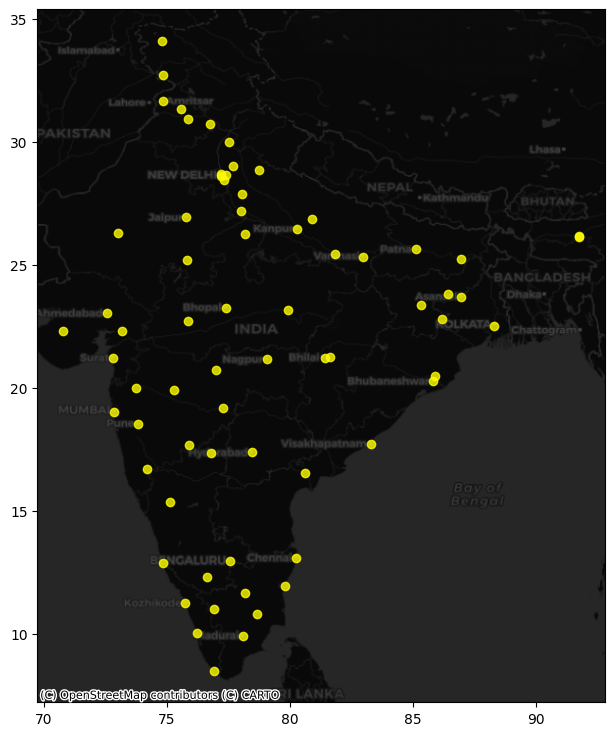

In [56]:
f, ax = plt.subplots(1, figsize=(9, 9))
places.plot(ax=ax, color="xkcd:bright yellow", alpha=0.8)
cx.add_basemap(ax=ax, crs=places.crs, source=cx.providers.CartoDB.DarkMatter)
plt.show()

---
With this at hand, get to work:

### Use the DBSCAN algorithm to identify clusters
- Start with the following parameters: at least five cities for a cluster (`min_samples`) and a maximum of 1.000 Km (`eps`)
- Obtain the clusters and plot them on a map. 
- Based on the results above, tweak the values of both parameters to find a cluster of southern cities, and another one of cities in the North around New Dehli

**Hint:** By default, place locations are expressed in longitude and latitude. Because you will be working with distances, it makes sense to convert the table into a system expressed in metres. For India, this can be the ["Kalianpur 1975 / India zone I"](http://epsg.io/24378) (`EPSG:24378`) projection.

In [59]:
## Express points in metres
# Convert lon/lat into Point objects + set CRS
pts = gpd.points_from_xy(
    places["longitude"],
    places["latitude"],
    crs="EPSG:4326"
)

# Convert lon/lat points to India CRS in metres
pts = gpd.GeoDataFrame({"geometry": pts}).to_crs(epsg=24378)

# Extract coordinates from point objects into columns
places["X_metres"] = pts.geometry.x
places["Y_metres"] = pts.geometry.y

places.head()

scalerank  natscale  labelrank        name namepar  namealt  diffascii  \
0          4        50          1  Chandigarh    None     None          0   
1          4        50          1       Jammu    None     None          0   
2          4        50          1    Sholapur    None  Solapur          0   
3          4        50          1  Aurangabad    None     None          0   
4          4        50          1       Nasik    None   Nashik          0   

    nameascii  adm0cap  capalt  ... rank_min  geonameid    meganame  \
0  Chandigarh        0       0  ...       11    1274746  Chandigarh   
1       Jammu        0       0  ...       10    1269321       Jammu   
2    Sholapur        0       0  ...       11    1256436     Solapur   
3  Aurangabad        0       0  ...       12    1278149  Aurangabad   
4       Nasik        0       0  ...       12    1261731      Nashik   

       ls_name ls_match checkme     featureclass                   geometry  \
0   Chandigarh        1       5  Admin-1 capital  POINT (76.77806 30.72194)   
1        Jammu        1       0  Populated place  POINT (74.84479 32.71373)   
2     Sholapur        1       0  Populated place  POINT (75.89806 17.67235)   
3  Aurangabad2        1       0  Populated place  POINT (75.31836 19.89764)   
4        Nasik        1       0  Populated place  POINT (73.77804 20.00236)   

       X_metres       Y_metres  
0  3.582595e+06  751858.275469  
1  3.383902e+06  958475.649414  
2  3.606801e+06 -712167.170690  
3  3.526186e+06 -464409.273259  
4  3.360971e+06 -462699.886135  

[5 rows x 39 columns]

In [174]:
# Set up algorithm
algo = DBSCAN(eps=200_000, min_samples=5)

#fit clustering algorithm
algo.fit(places[["X_metres", "Y_metres"]])

#add labels as new columns
places['cluster_label'] = pd.Series(algo.labels_, index=places.index)

#count # points assigned to each cluster
places['cluster_label'].value_counts()

cluster_label
-1    34
 1    15
 3     9
 2     6
 0     5
Name: count, dtype: int64

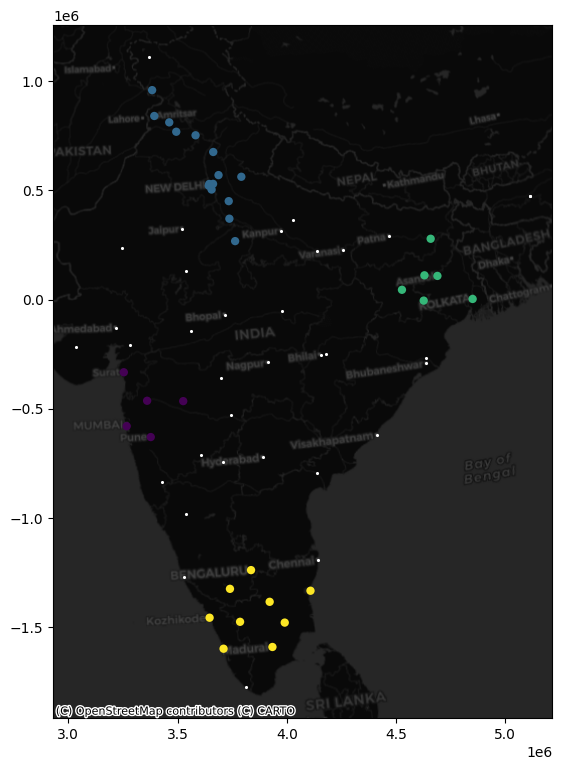

In [175]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Create subset of the dataframe to split noise and cluster(ed) points
noise_points = places.loc[places['cluster_label']==-1]
cluster_points = places.loc[places['cluster_label']!=-1]

# Plot noise in grey
ax.scatter(
    noise_points["X_metres"], 
    noise_points["Y_metres"], 
    c='white', 
    s=5, 
    linewidth=0
)

# Plot cluster(ed) points with a color for each cluster
ax.scatter(
    cluster_points["X_metres"], 
    cluster_points["Y_metres"],
    c=cluster_points["cluster_label"],
    linewidth=0
)

#add a basemap
cx.add_basemap(ax=ax, crs=places.to_crs(epsg=24378).crs, source=cx.providers.CartoDB.DarkMatter)

# Display the figure
plt.show()

### Analyze your results. Answer at least the following:

- *What parameters have you used to run DBSCAN? Why?*
- *Does it pick up any interesting pattern?* If so, *What do the clusters help you learn about areas of interest in the city?*

#### Answer the question here:

*What parameters have you used to run DBSCAN? Why?*

We've selected eps = 200 km and min_samples = 5 because that let us have 4 different clusters with an interesting pattern. It creates 4 different clusters one in each side of the country (north, east, south and west)

*Does it pick up any interesting pattern?* If so, *What do the clusters help you learn about areas of interest in the city?*

Given the combination of selected parameters, we can conclude that each cluster is composed of cities that have other 5 "neighboring" cities within a 200km radius. Interestingly, the clusters include 4 of the most important cities in India: Dehli in the north, Mumbai in the east, Kolkata in the west, and Bangalore in the south.
